In [6]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import re

In [7]:
class SentenceEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-mpnet-base-v2'):
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.model.encode(X, show_progress_bar=True)

Model Validation & Data Strategy
1. Integrating Hugging Face Datasets
To rigorously test the model's accuracy, we utilized the Resume Screening Dataset from Hugging Face. This provides a diverse benchmark of real-world CVs across multiple domains.

2. Refining the Evaluation Logic (Skill-Based vs. Administrative)
While the dataset includes labels for "Accepted" or "Rejected", our system adopts a more objective Semantic Matching approach.

The Problem with Labels: Upon analyzing the Reason column in the dataset, many resumes were "Rejected" due to factors external to the Job Description (softskills).

The Solution: creating a "Random Baseline" (Incorrect Data)(more illustration  about before it is cell


In [8]:
import pandas as pd

df = pd.read_csv("hf://datasets/AzharAli05/Resume-Screening-Dataset/dataset.csv")


In [9]:
def clean_text(text):
    # del HTML tags
    text = re.sub(r"<.*?>", "", text)

    # del email
    text = re.sub(r"\S+@\S+", "[EMAIL]", text)

    # del extra spaces
    text = re.sub(r"\s+", " ", text)

    # make  lowercase
    text = text.lower()

    return text.strip()


In [10]:
# Ensure the dataset has the required columns
# Use this assertion to catch data format issues early
assert 'Resume' in df.columns and 'Job_Description' in df.columns, "Missing required columns"


In [11]:

#apply clean on resume col
df["Resume"] = df["Resume"].apply(clean_text)

In [12]:
def generate_embeddings(df):

    pipeline = Pipeline([('embedder', SentenceEmbeddingTransformer())])

    resume_embeddings = pipeline.transform(df['Resume'])

    job_embeddings = pipeline.transform(df['Job_Description'])


    return resume_embeddings, job_embeddings


In [13]:
resume_embeddings, job_embeddings=generate_embeddings(df)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/318 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Batches:   0%|          | 0/318 [00:00<?, ?it/s]

In [14]:
similarities = [
    cosine_similarity([resume_embeddings[i]], [job_embeddings[i]])[0][0]
    for i in range(len(df))]
df['match_score'] = np.array(similarities) * 100



To verify that the model is truly capturing the semantic relationship between resumes and jobs by creating a "Random Baseline" (Incorrect Data).

1.  Shuffle Data: We randomize the Resume column so that resumes no longer match their original labels/jobs.
2.  Generate Embeddings: We process this shuffled data through the model to get "Wrong" embeddings.
3.  Validation: By comparing these to the original data, we ensure the model's similarity scores mean for random pairs are significantly lower than for correct pairs. This proves the model isn't giving high scores by chance.

In [15]:
df_wrong = df.copy()
df_wrong['Resume'] = df['Resume'].sample(frac=1).values
resume_embeddingsw, job_embeddingsw=generate_embeddings(df_wrong)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/318 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Batches:   0%|          | 0/318 [00:00<?, ?it/s]

In [16]:
similaritiesw = [
    cosine_similarity([resume_embeddingsw[i]], [job_embeddingsw[i]])[0][0]
    for i in range(len(df))]
df_wrong['match_score'] = np.array(similaritiesw) * 100


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_simple_distribution(df,s):
    """
    رسم توزيع نسب المطابقة (Match Scores) مع توضيح المتوسط والوسيط فقط.
    """
    plt.figure(figsize=(12, 6))

    # رسم الهيستوجرام مع منحنى الكثافة (KDE)
    sns.histplot(df['match_score'], bins=50, kde=True, color='skyblue', edgecolor='black')

    # إضافة خط المتوسط (Mean)
    mean_val = df['match_score'].mean()
    plt.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')

    # إضافة خط الوسيط (Median)
    median_val = df['match_score'].median()
    plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')

    # جماليات الرسم
    plt.title(s)
    plt.xlabel(s+' (%)')
    plt.ylabel('Count')
    plt.legend()

    plt.show()



in plot The shift in the distribution mean from 54.23% (Original) to 39.62% (Shuffled) proves that the model successfully distinguishes between relevant and random Resume-Job pairs.

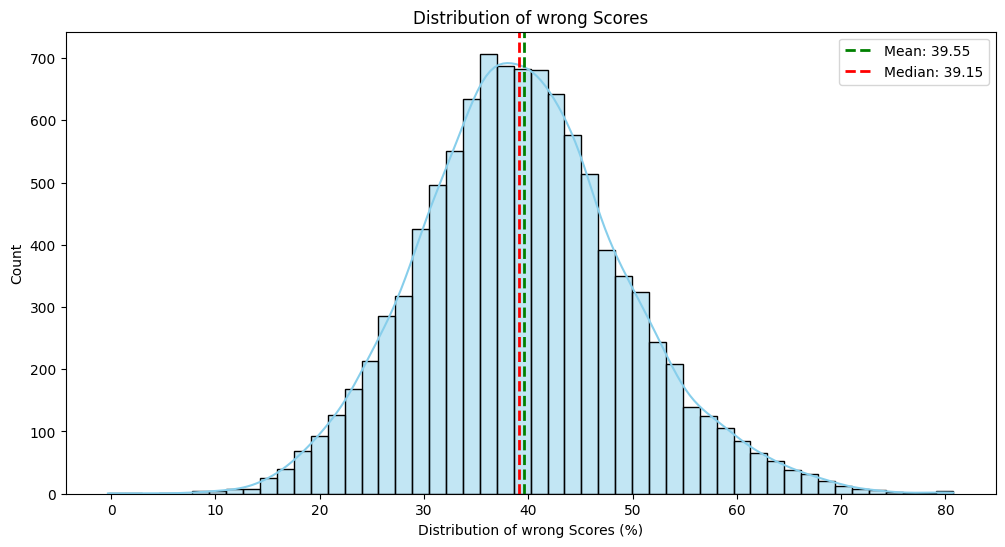

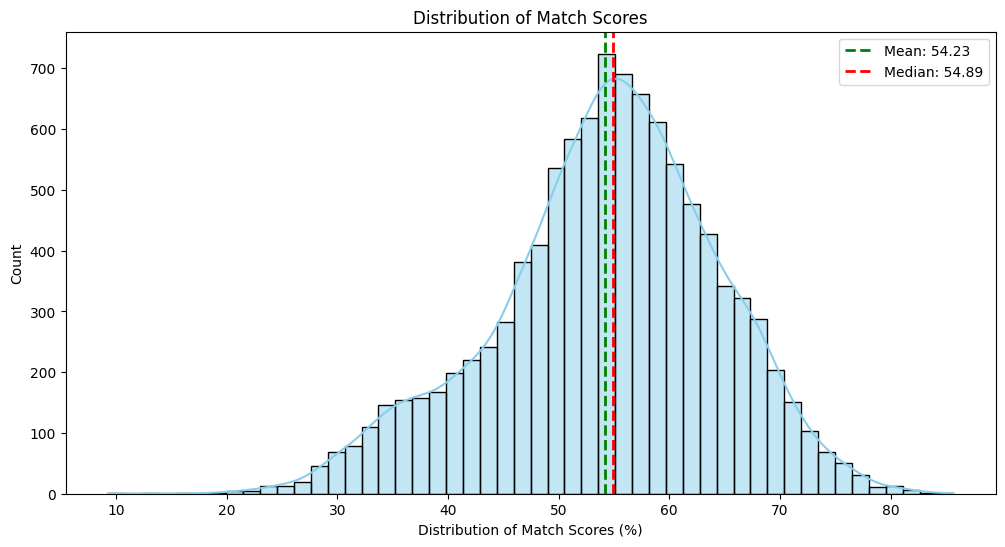

In [18]:
plot_simple_distribution(df_wrong,'Distribution of wrong Scores')
plot_simple_distribution(df,'Distribution of Match Scores')


test model on real job describtion

In [20]:

from sklearn.metrics.pairwise import cosine_similarity
import re

def rank_resumes(job_text, resume_df, pipeline, top_n=5):
    """It sorts all resumes from highest to lowest score and returns the top $N$ candidates.
    job_text:job des
    resume_df:from data_set"""
    job_embedding = pipeline.transform([job_text])

    resume_embeddings = pipeline.transform(resume_df['Resume'])

    scores = cosine_similarity(job_embedding, resume_embeddings).flatten()

    resume_df['match_score'] = scores * 100

    def get_reason(resume_txt):
        res_words = set(re.findall(r'\w+', resume_txt.lower()))
        job_words = set(re.findall(r'\w+', job_text.lower()))
        common = [w for w in res_words.intersection(job_words) if len(w) > 3]
        return f"Matches key terms: {', '.join(common[:10])}"

    resume_df['justification'] = resume_df['Resume'].apply(get_reason)

    ranked_results = resume_df.sort_values(by='match_score', ascending=False).head(top_n)

    return ranked_results[['Resume', 'match_score','justification']]

In [21]:
top=rank_resumes(job_text = " professionals who hire, screen and plan for new employees to create a positive work environment. They consult with executives to .", resume_df = df, pipeline = Pipeline([('embedder', SentenceEmbeddingTransformer())]), top_n = 5)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Batches:   0%|          | 0/318 [00:00<?, ?it/s]

In [36]:
for i in top.values:
    print(i)

["marcia wilkinson contact information: * address: 123 main street, anytown, usa 12345 * phone: (555) 555-5555 * email: [email] * linkedin: linkedin.com/in/marciawilkinson professional summary: results-driven human resources professional with 8+ years of experience in recruitment, onboarding, training and development, and conflict resolution. proven track record of improving employee engagement, reducing turnover, and enhancing organizational performance. skilled in creating and implementing hr strategies that drive business results. summary of qualifications: * bachelor's degree in business administration or related field * shrm-cp or phr certification (optional) * experience with hris systems, such as workday or adp * strong communication, interpersonal, and problem-solving skills * ability to work in a fast-paced environment and prioritize multiple tasks professional experience: human resources coordinator, abc corporation (2018-present) * recruit, onboard, and train new hires to me

In [4]:
#To download a specialized job-skills dataset and convert it into a structured JSON cause first data set not has skill col
import kagglehub
import pandas as pd
import json

path = kagglehub.dataset_download("batuhanmutlu/job-skill-set")

import os
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)

df = pd.read_csv(full_path)

df_clean = df[['job_title', 'job_skill_set']].dropna()

data_to_save = df_clean.to_dict(orient='records')

json_file_path = "job_skills_data.json"

with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=4)


print(json.dumps(data_to_save[:2], indent=4, ensure_ascii=False))

100%|██████████| 1.50M/1.50M [00:00<00:00, 2.65MB/s]

Extracting files...
[
    {
        "job_title": "Sr Human Resource Generalist",
        "job_skill_set": "['employee relations', 'talent acquisition', 'performance management', 'compensation and benefits', 'employment laws and regulations', 'analytical skills', 'employee benefits administration', 'HR policies and procedures', 'recruitment strategies', 'FMLA', 'ADA', 'communication', 'interpersonal skills', 'collaboration', 'influence', 'change management', 'professional development', 'payroll processing', 'job design', 'salary administration', 'human capital management system', 'HR audits and assessments', 'FLSA', 'ERISA', 'EEOC guidelines', 'confidentiality', 'intellectual curiosity']"
    },
    {
        "job_title": "Human Resources Manager",
        "job_skill_set": "['Talent Acquisition', 'Employee Performance Management', 'Legal Compliance', 'Payroll Processing', 'Microsoft Office', 'Policy Development', 'Training and Development', 'Background Checks', 'Collaboration', 'Communi

start bulding flask app

During model evaluation, it was observed that the Mean Cosine Similarity for correct matches was 54.23%, while random matches averaged 39.62%. From a mathematical perspective, this is a clear distinction. However, from a User Experience (UX) perspective, a user seeing a '54% match' for a high-quality resume might perceive the AI as inaccurate or failing. To address this, I implemented a Square Root scaling function. In my opinion, using the square root is superior to adding fixed points because it inherently prevents the score from exceeding 100%, ensuring the output remains logical and user-friendly.

Cosine Similarity often suffers from Length Bias. When a resume is very long, the core skills and relevant experience can get 'diluted' or lost in the background noise of administrative text,
leading to a misleadingly low score. Standard models might struggle to find the 'signal' in a 5-page document.
so
Instead of processing the entire resume as a single block, I implemented a Sliding Window Chunking strategy. The resume is split into smaller, overlapping segments (Chunks).

Maximum Similarity (Max-Pooling): We calculate the similarity for each individual chunk against the job description and take the Maximum Score (torch.max).

In [1]:
!pip install flask flask-ngrok spacy pdfplumber python-docx sentence-transformers -q
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import os
import json
import torch
import pdfplumber
import docx
import spacy
import ast
import math
from flask import Flask, request
from sentence_transformers import SentenceTransformer, util
from google.colab.output import eval_js
app = Flask(__name__)

model = SentenceTransformer('all-MiniLM-L6-v2')
try:
    nlp = spacy.load("en_core_web_sm") # for NER
except:
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def extract_text(file):
    fname = file.filename.lower()
    if fname.endswith('.pdf'):
        with pdfplumber.open(file) as pdf:
            return " ".join([p.extract_text() for p in pdf.pages if p.extract_text()])
    elif fname.endswith('.docx'):
        doc = docx.Document(file)
        return " ".join([p.text for p in doc.paragraphs])
    return file.read().decode('utf-8')

def get_person_name(text): #to extract person name
    doc = nlp(text[:500])
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            return ent.text
    return "unknown"

def get_companies(text):#to extract past experince
    doc = nlp(text)
    companies = set([ent.text.strip() for ent in doc.ents if ent.label_ == "ORG"])
    return list(companies)[:5]

def load_jobs():#the json come from data set
    try:
        with open('job_skills_data.json', 'r', encoding='utf-8') as f:
            return json.load(f)
    except:#If the JSON file is missing or corrupted, the app won't crash. Instead, it loads a 'Default Job' (Python Developer) to keep the system functional.
        return [{"job_title": "Python Developer", "job_description": "Experience with Flask", "job_skill_set": "['Python', 'Flask', 'SQL']"}]

@app.route('/')
def home():
    return '''
    <div style="text-align:center; padding:100px; font-family:sans-serif; background:#f4f7f6; height:100vh;">
        <div style="background:white; padding:40px; display:inline-block; border-radius:15px; box-shadow:0 4px 15px rgba(0,0,0,0.1);">
            <h2 style="color:#2c3e50;">🧪 Smart CV Scanner </h2>
            <p style="color:#7f8c8d;"> Upload your file (PDF/DOCX) to analyze and match it with top job roles</p>
            <form action="/test" method="post" enctype="multipart/form-data">
                <input type="file" name="resume" required style="margin:20px 0;"><br>
                <button type="submit" style="padding:12px 30px; background:#27ae60; color:white; border:none; border-radius:5px; cursor:pointer; font-size:16px;">start now</button>
            </form>
        </div>
    </div>
    '''

@app.route('/test', methods=['POST'])
def test():
    if 'resume' not in request.files: return "no uploaded file"

    file = request.files['resume']
    text = extract_text(file)

    person_name = get_person_name(text)
    detected_companies = get_companies(text)

    chunks = [text[i:i+400] for i in range(0, len(text), 250)]
    chunk_embeddings = model.encode(chunks, convert_to_tensor=True)

    jobs = load_jobs()
    job_texts = [j.get('job_description', j['job_title']) for j in jobs]
    job_embeddings = model.encode(job_texts, convert_to_tensor=True)

    sim_matrix = util.cos_sim(chunk_embeddings, job_embeddings)
    raw_score = torch.max(sim_matrix).item()

    boosted_score = math.sqrt(max(0, raw_score)) * 100
    final_display_score = round(min(boosted_score, 99.9), 1)
    #choose biggest num im tensor
    flat_idx = torch.argmax(sim_matrix).item()

    chunk_idx = flat_idx // len(jobs)
    job_idx = flat_idx % len(jobs)
    raw_skills = jobs[job_idx].get('job_skill_set', [])
    try:
        #hadel"["python","java"]" list write as str
        job_skills_list = ast.literal_eval(raw_skills) if isinstance(raw_skills, str) else raw_skills
    except:
        job_skills_list = [s.strip() for s in str(raw_skills).split(',')]

    skills_html = "".join([f'<span style="background:#3498db; color:white; border-radius:20px; padding:5px 15px; margin:5px; display:inline-block; font-size:12px;">{s}</span>' for s in job_skills_list])
    companies_html = ", ".join(detected_companies) if detected_companies else "unknown"

    return f'''
    <div style="max-width:750px; margin:40px auto; padding:30px; font-family:'Segoe UI', Arial; direction:rtl; line-height:1.8; background:#fff; border-radius:15px; box-shadow:0 10px 30px rgba(0,0,0,0.15);">
        <h2 style="color:#2c3e50; text-align:center;">📊 Result for : {person_name}</h2>

        <div style="display:flex; justify-content:space-between; align-items:center; background:#f8f9fa; padding:20px; border-radius:12px; margin:25px 0; border-right:5px solid #27ae60;">
            <div>
                <span style="color:#7f8c8d; font-size:14px;">  job_title :</span><br>
                <strong style="font-size:1.4em; color:#2c3e50;">{jobs[job_idx]['job_title']}</strong>
            </div>
            <div style="text-align:center;">
                <span style="color:#7f8c8d; font-size:14px;">  score </span><br>
                <div style="font-size:32px; font-weight:bold; color:#27ae60;">{final_display_score}%</div>
            </div>
        </div>

        <div style="margin-bottom:20px;">
            <b style="color:#e67e22;">👤  name :</b> {person_name}
        </div>

        <div style="margin-bottom:25px;">
            <b style="color:#2980b9;">🏢  past experince:</b> {companies_html}
        </div>

        <div style="margin-bottom:25px;">
            <b style="color:#2c3e50;">🛠 needed skills:</b><br>
            <div style="padding-top:10px;">{skills_html}</div>
        </div>

        <div style="text-align:center; margin-top:40px;">
            <a href="/" style="text-decoration:none; background:#2c3e50; color:white; padding:12px 35px; border-radius:8px;"> new test </a>
        </div>
    </div>
    '''

if __name__ == '__main__':
    try:
        print("---")
        print("اضغط على الرابط بالأسفل لفتح الواجهة:")
        print(eval_js("google.colab.kernel.proxyPort(5000)"))
        print("---")
    except:
        pass
    app.run(port=5000)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


---
اضغط على الرابط بالأسفل لفتح الواجهة:
https://5000-gpu-t4-s-g2jgehzft5at-b.europe-west4-2.prod.colab.dev
---
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:14:56] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:14:56] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:15:22] "POST /test HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:15:56] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:16:36] "POST /test HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:19:04] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:26:08] "POST /test HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:26:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:27:45] "POST /test HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 01:28:00] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 -